# "Pump it Up: Data Mining the Water Table"

Jason & Tom

In [2]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import string

# Data Wrangling & Pre-Processing

This notebook explains the steps we took to initially understand our data, and the clean and pre-process it into a format that we thought was suitable.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us.

In [3]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## 1.0 Initial Understanding / Data Quality Assesment

In [5]:
df.shape

(59400, 41)

In [6]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Some notes on ```df.describe()```

amount_tsh (total vertical distance pump carries the water from source to tap (m))

    - max value of 350000 seems excessively high, we should look into that
    - especially when the max gps height is only 2770m (gps height is height of pump from sea-level).
   

population

    - why is min & 25% = 0, what does this mean - is this an error or is there actually no people in these areas

construction_year

    - a lot of 0 values, we will definitely need to impute this, perhaps based off waterpoint type/district rather than the mean (although we can try both).

In [11]:
# percent of data that has construction year 0

df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0] * 100

34.86363636363636

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]

null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


Some notes on missing data:

    - scheme_name has too many missing values to be useful, we should drop this column.
    - scheme_management - this is a useful column so we shouldn't drop it, we could either replace all missing values with 'Other', (as we will likely have to do that anyway)
    - installer - same as scheme_management
    - funder - same as scheme_management
    - public_meeting - more information needed
    - permit - more information needed
    - subvillage we can impute based off other geographical data, perhaps using clustering, or we can drop as there might be too many unique values.

## 1.1 Checking Each Columns Values & Quality

**Unless specified, everything in section 1.1 was performed by Jason.**

### 1.1.1 Funder

In [14]:
df['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1897, dtype: int64

In [15]:
df['funder'].isna().sum()

3635

In [16]:
len(df['funder'].unique())

1898

Observations :
- **777** rows contains 0's as their Funder.
- **3635** rows contain NaN values.
- **1898** Unique Elements including NaN.
- Spelling Mistakes are present for similar funder names. Exp: Zao Water Spring & Zao Water Spring X

Suggestions :
- This column might be not important for the modelling process and could be ignored.
- However, binning could be done to classify Funders as a group if required.

### 1.1.2 Installer

In [19]:
df['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2145, dtype: int64

In [20]:
df['installer'].isna().sum()

3655

In [22]:
len(df['installer'].unique())

2146

Observations :
- **780** rows contain 0 or - as Installer.
- **3655** rows contain NaN values.
- **2146** Unique Elements including NaN.
- Spelling Mistakes are present for similar Installer names. Exp: Dr. Matomola, Dr.Matomola.

Suggestions :
- Spelling Mistakes would have to be corrected at the future if this column is important.
- Binning would have to be done to reduce num of unique instances.

### 1.1.3 Subvillage / Region

In [23]:
df['subvillage'].value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

In [24]:
df['subvillage'].isna().sum()

371

In [26]:
len(df['subvillage'].unique())

19288

Observations :
- Has large number of subvillage's name.
- **371** rows containing NaN data.

Suggestions :
- Drop this column and use **Region** column instead as villages are assigned based on region.

### 1.1.4 Region

In [28]:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [29]:
df['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

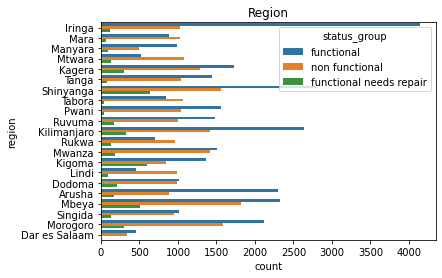

In [31]:
sns.countplot(data=df, y='region', hue='status_group', dodge=1.0)
plt.title('Region')
plt.show()

Observations :
- A region would have the same region code but can have different **district** code.
- Can drop **ward** and **lga** which could be represented by Region.

### 1.1.5 Public Meeting

In [33]:
df['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [35]:
df['public_meeting'].isna().sum()

3334

In [36]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

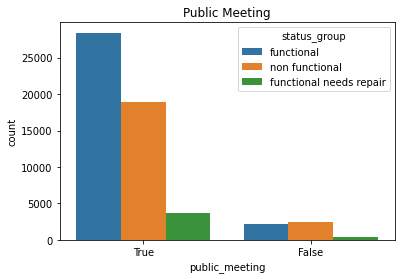

In [38]:
sns.countplot(data=df, x='public_meeting', hue='status_group', dodge=1.0)
plt.title('Public Meeting')
plt.show()

Observations :
- **3334** rows of NaN data.
- Two elements only True or False.
- Likely to be **not important**.

### 1.1.6 Scheme Management

In [41]:
df['scheme_management'].unique()

array(['VWC', 'Other', nan, 'Private operator', 'WUG', 'Water Board',
       'WUA', 'Water authority', 'Company', 'Parastatal', 'Trust', 'SWC',
       'None'], dtype=object)

In [42]:
df['scheme_management'].isna().sum()

3877

In [43]:
df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

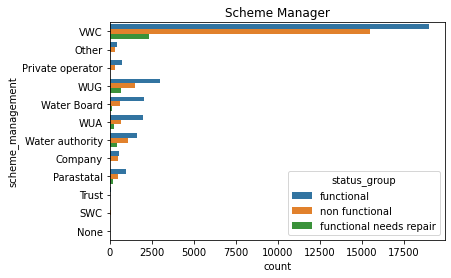

In [45]:
sns.countplot(data=df, y='scheme_management', hue='status_group', dodge=1.0)
plt.title('Scheme Manager')
plt.show()

Observations :
- **3877** rows of NaN data.
- Data is relatively clean.
- scheme_management may not have a scheme_name for each water well altough operated by the same provider

Suggestions :
- Perform data imputation on scheme_management through multivariate chained imputation.
- Use scheme_management and drop **scheme_name** if required.

### 1.1.7 Permit

In [47]:
df['permit'].unique()

array([False, True, nan], dtype=object)

In [48]:
df['permit'].isna().sum()

3056

In [49]:
df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

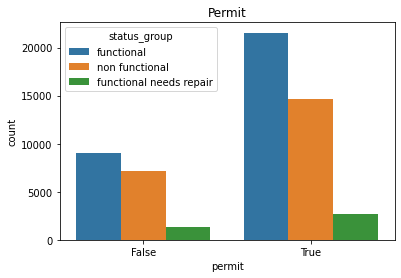

In [51]:
sns.countplot(data=df, x='permit', hue='status_group', dodge=1.0)
plt.title('Permit')
plt.show()

Observations :
- **3056** rows of NaN data.
- Two categories only : True or False

Suggestions :
- Could be dropped if not important.

### 1.1.8 Construction Year

In [54]:
df.sort_values(by='construction_year', inplace=True)
df['construction_year'].unique()

array([   0, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [55]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Text(0, 0.5, 'No of Instances')

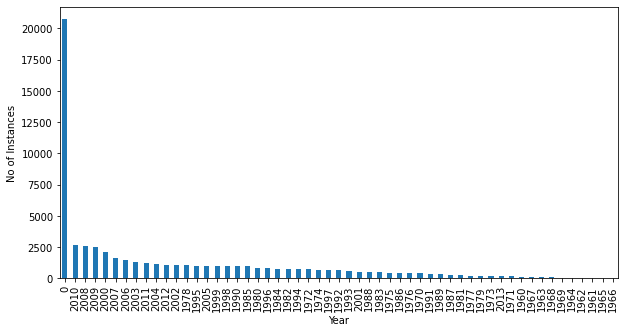

In [56]:
plt.figure(figsize=(10,5))
df['construction_year'].value_counts().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("No of Instances")

Observations :
- Approximately **40%** of rows has construction year of value **0**.

Suggestions :
- Perform data imputation.
- Remain as it is as last resort.

Because of the number of 0's, we took some extra time to check the correlation of `construction_year` to other features, to see if we could use those features to impute the 0 values.

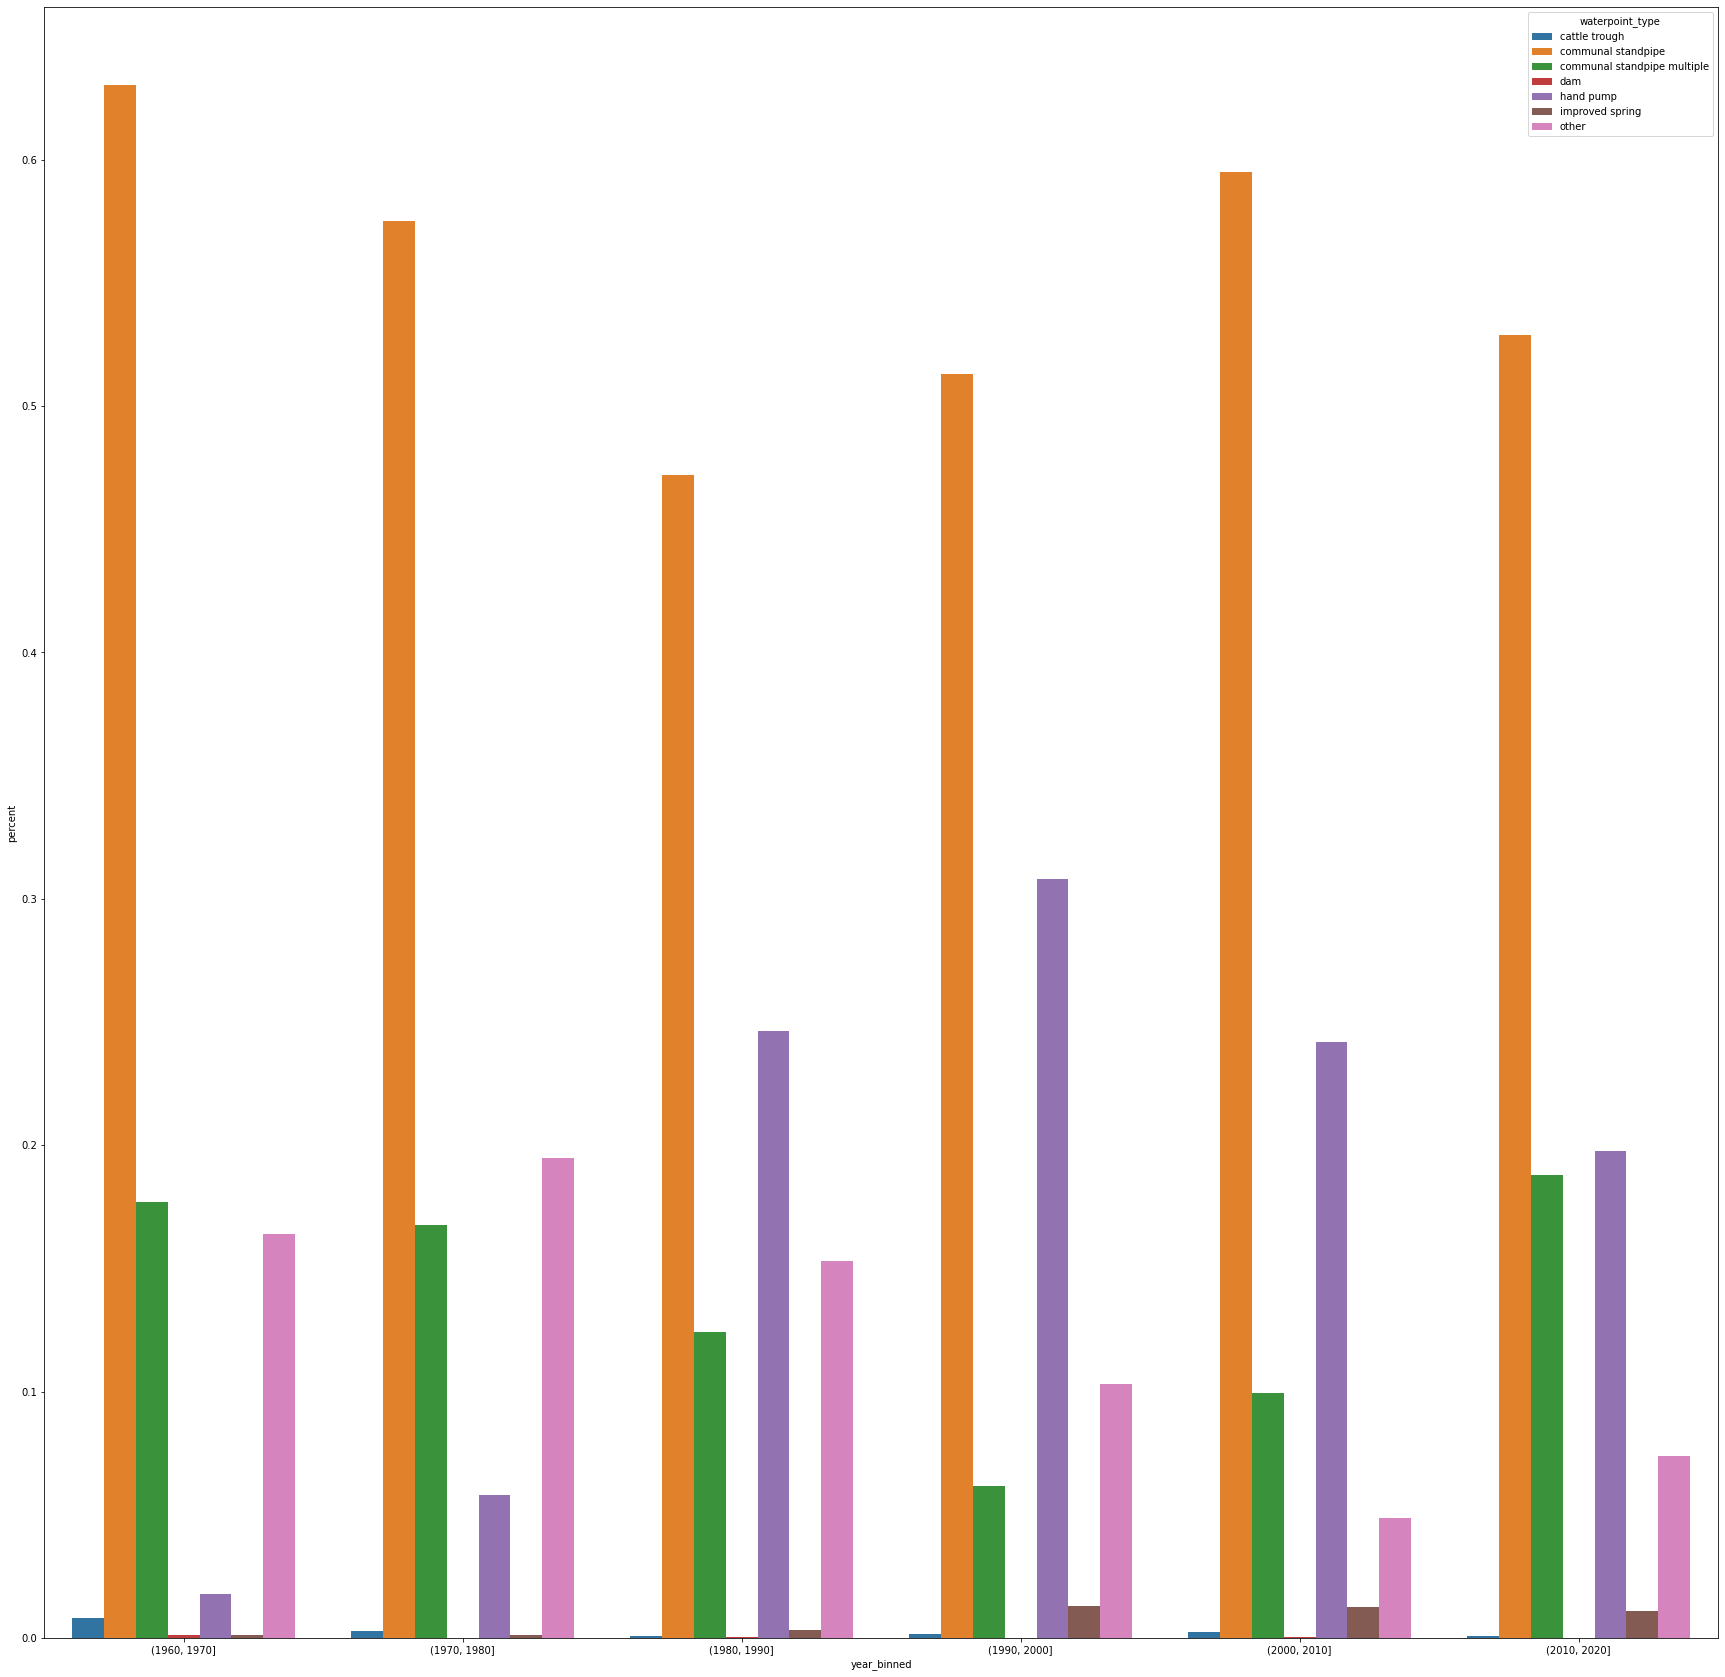

In [58]:
# Author [Tom]

# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

There doesn't seem to be much correlation between the waterpoint_type and construction year. There are two points:

    - 'other' usage goes down as time progresses
    - 'hand pump' usage goes up as time progresses

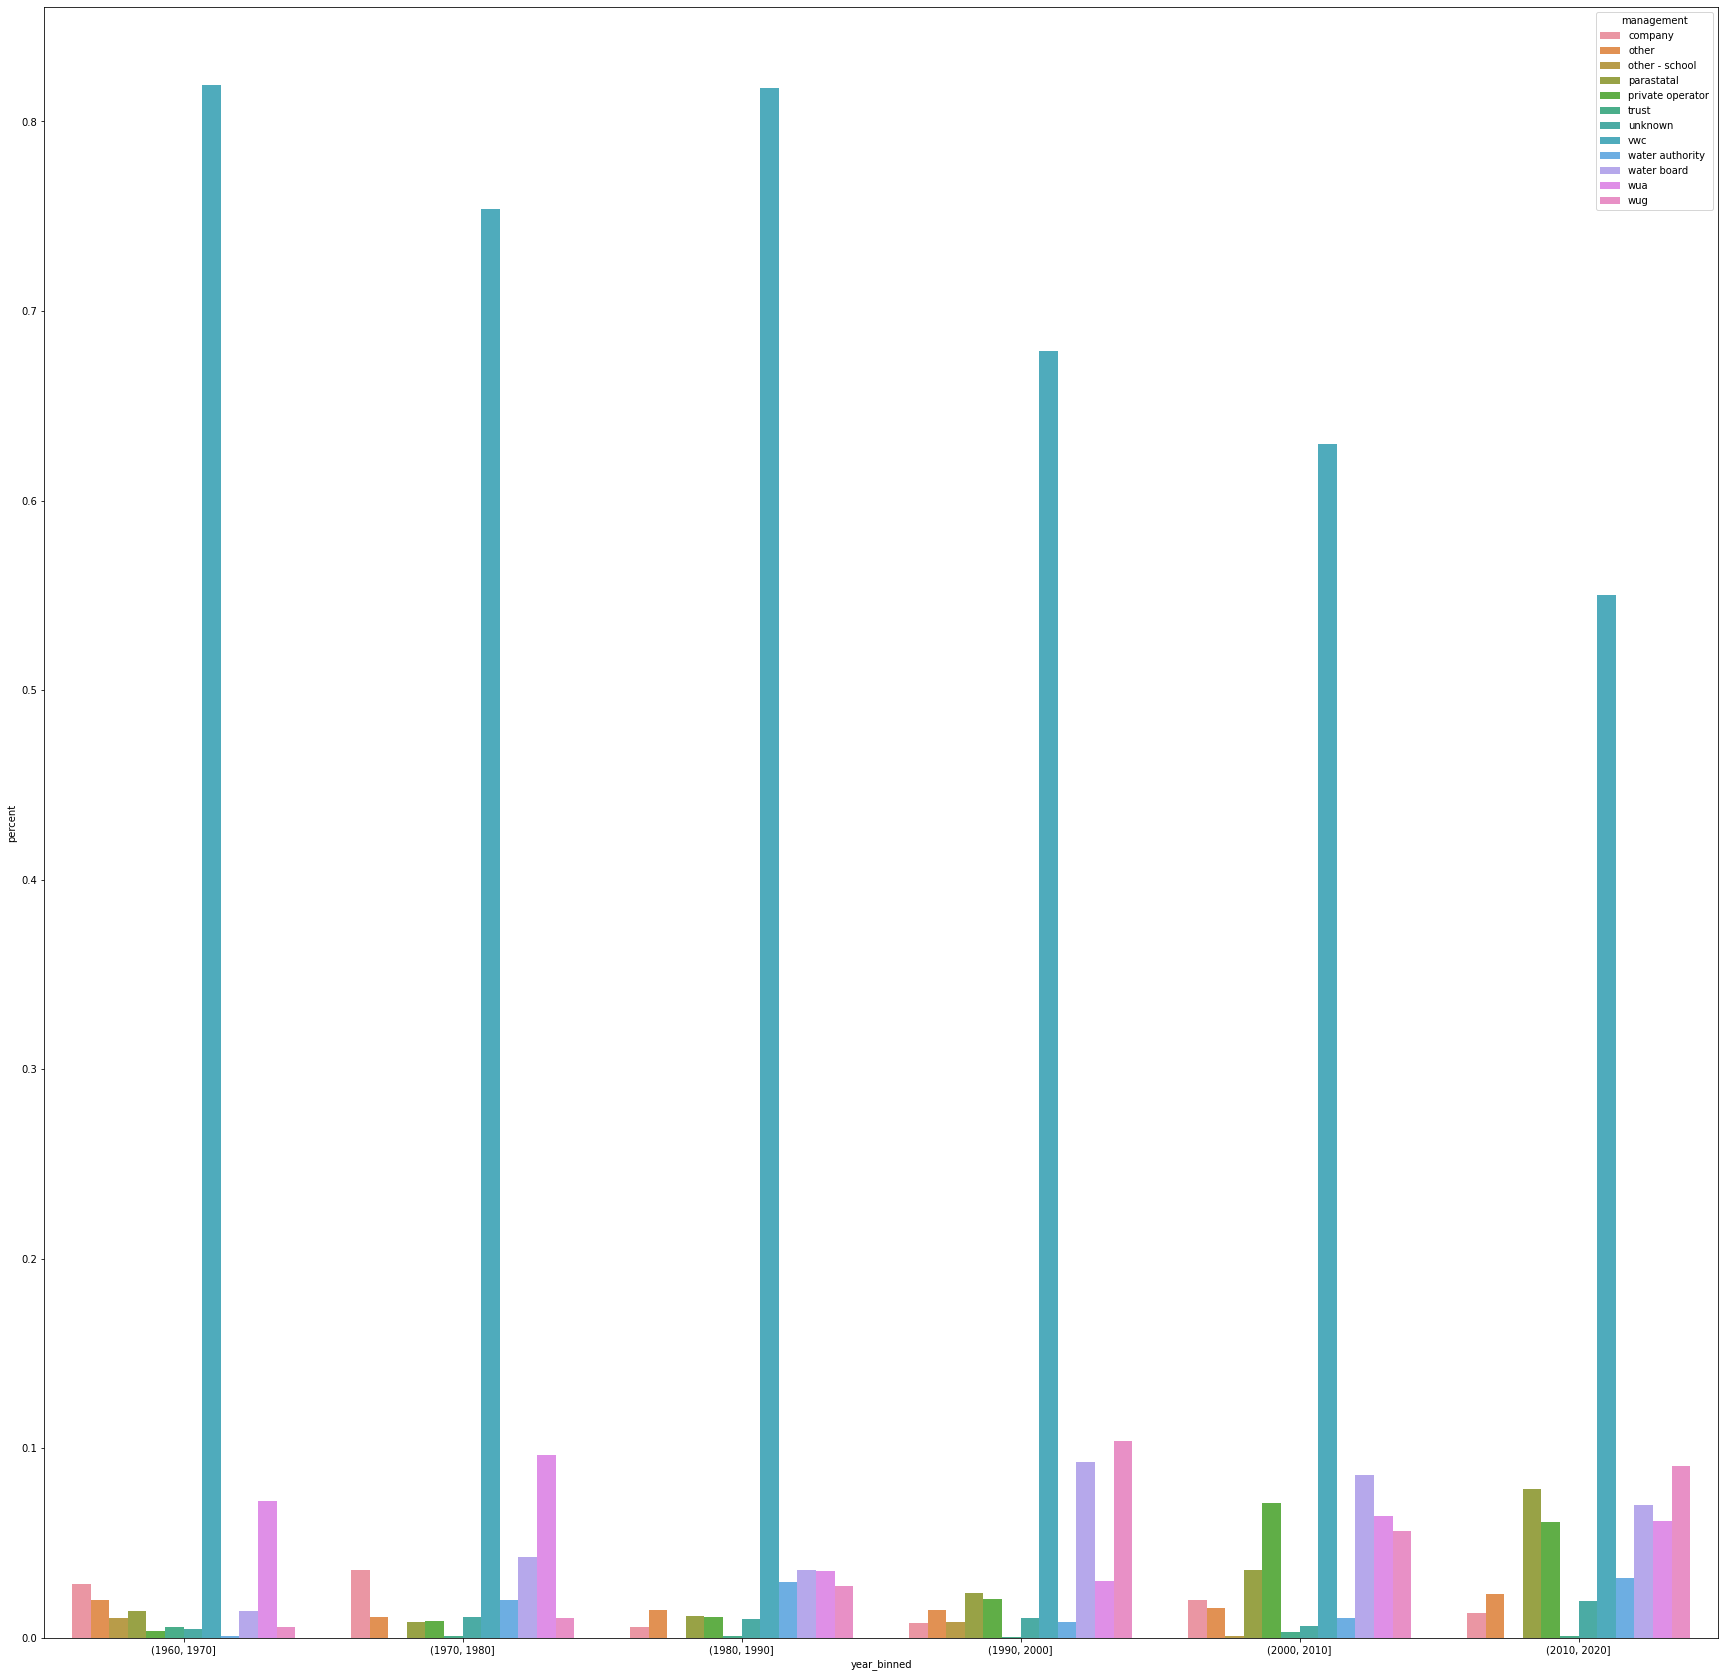

In [59]:
# Author [Tom]

df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

Interesting point here, 'parastatal' and 'private' definitely go up in percentage installed as the years increase.

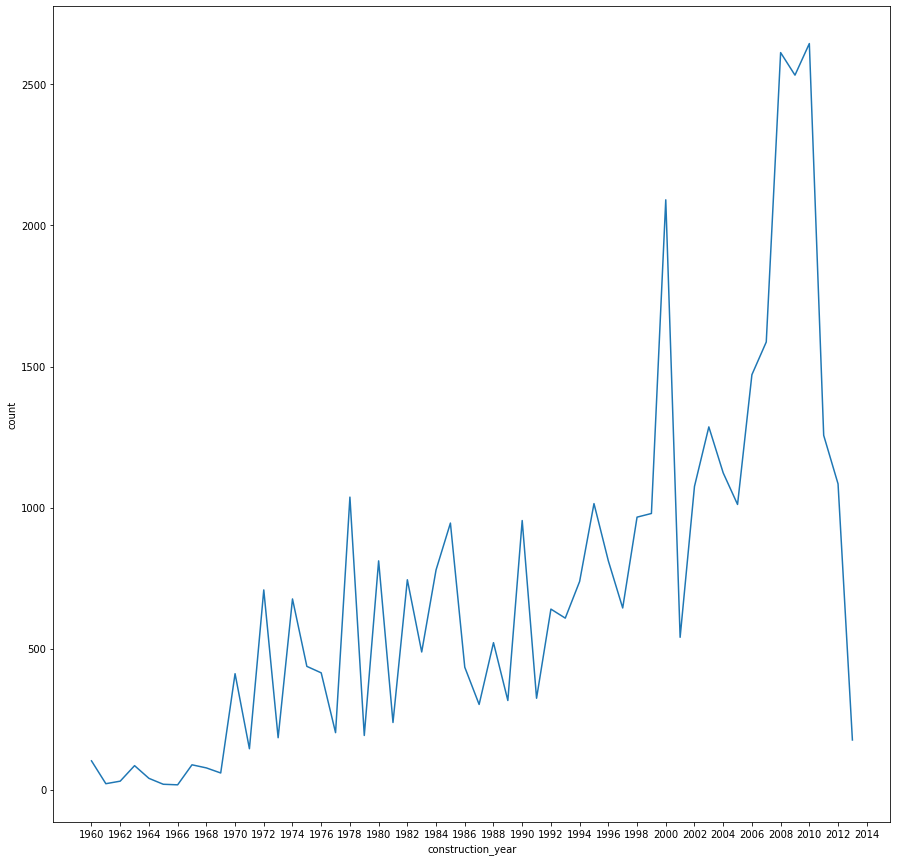

In [60]:
# Author [Tom]

df_years = df_test.groupby('construction_year').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

### 1.1.9 Extraction_Type / Extraction_Type_Group / Extraction_Type_Class

In [62]:
df.sort_values(by='extraction_type', inplace=True)
print(df['extraction_type'].unique())

df.sort_values(by='extraction_type_group', inplace=True)
print(df['extraction_type_group'].unique())

df.sort_values(by='extraction_type_class', inplace=True)
print(df['extraction_type_class'].unique())

['afridev' 'cemo' 'climax' 'gravity' 'india mark ii' 'india mark iii'
 'ksb' 'mono' 'nira/tanira' 'other' 'other - mkulima/shinyanga'
 'other - play pump' 'other - rope pump' 'other - swn 81' 'submersible'
 'swn 80' 'walimi' 'windmill']
['afridev' 'gravity' 'india mark ii' 'india mark iii' 'mono' 'nira/tanira'
 'other' 'other handpump' 'other motorpump' 'rope pump' 'submersible'
 'swn 80' 'wind-powered']
['gravity' 'handpump' 'motorpump' 'other' 'rope pump' 'submersible'
 'wind-powered']


In [64]:
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [65]:
df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [66]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [68]:
print(len(df['extraction_type'].unique()))

print(len(df['extraction_type_group'].unique()))

print(len(df['extraction_type_class'].unique()))

18
13
7


Text(0.5, 1.0, 'Extraction Type Class')

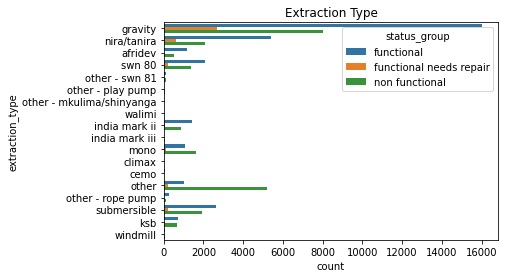

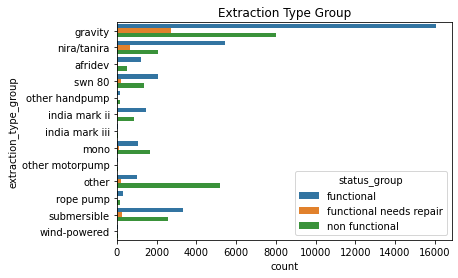

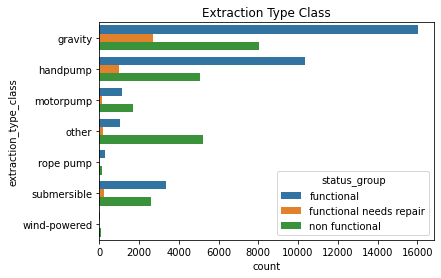

In [70]:
sns.countplot(data=df, y='extraction_type', hue='status_group', dodge=1.0)
plt.title('Extraction Type')

plt.figure()
sns.countplot(data=df, y='extraction_type_group', hue='status_group', dodge=1.0)
plt.title('Extraction Type Group')

plt.figure()
sns.countplot(data=df, y='extraction_type_class', hue='status_group', dodge=1.0)
plt.title('Extraction Type Class')

Observations :
- extraction_type has **18** categories.
- extraction_type_group has **13** categories.
- extraction_type_class has **7** categories.
- All 3 columns represent the extraction method the waterpoint uses.

Suggestions :
- Use **extraction_type_class** as it could represent the dataset in least number of categories.
- Drop **extraction_type** and **extraction_type_group**.

### 1.1.10 Management / Management Group

In [72]:
df.sort_values(by='management', inplace=True)
print(df['management'].unique())

df.sort_values(by='management_group', inplace=True)
print(df['management'].unique())

['company' 'other' 'other - school' 'parastatal' 'private operator'
 'trust' 'unknown' 'vwc' 'water authority' 'water board' 'wua' 'wug']
['company' 'private operator' 'water authority' 'trust' 'other'
 'other - school' 'parastatal' 'unknown' 'vwc' 'water board' 'wug' 'wua']


In [74]:
df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [75]:
df['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [77]:
print(len(df['management'].unique()))

print(len(df['management_group'].unique()))

12
5


Text(0.5, 1.0, 'Management Group')

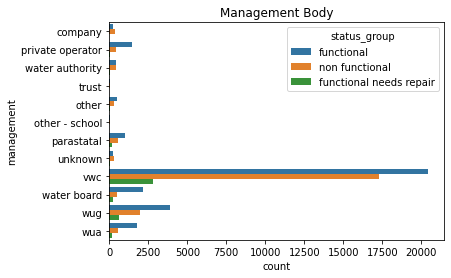

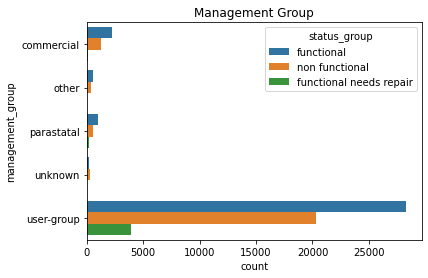

In [78]:
sns.countplot(data=df, y='management', hue='status_group', dodge=1.0)
plt.title('Management Body')

plt.figure()
sns.countplot(data=df, y='management_group', hue='status_group', dodge=1.0)
plt.title('Management Group')

Observations :
- extraction_type has **12** categories.
- extraction_type_group has **5** categories.
- Both columns represent the management of waterpoint.

Suggestions :
- Use management_group column and drop management column.

### 1.1.11 Payment / Payment_Type

In [80]:
df.sort_values(by='payment', inplace=True)
print(df['payment'].unique())

df.sort_values(by='payment_type', inplace=True)
print(df['payment_type'].unique())

['never pay' 'other' 'pay annually' 'pay monthly' 'pay per bucket'
 'pay when scheme fails' 'unknown']
['annually' 'monthly' 'never pay' 'on failure' 'other' 'per bucket'
 'unknown']


In [81]:
df['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [82]:
df['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [84]:
print(len(df['payment'].unique()))

print(len(df['payment_type'].unique()))

7
7


Text(0.5, 1.0, 'Payment Type')

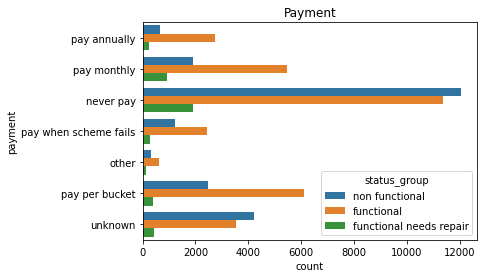

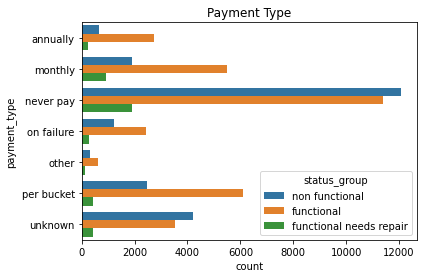

In [85]:
sns.countplot(data=df, y='payment', hue='status_group', dodge=1.0)
plt.title('Payment')

plt.figure()
sns.countplot(data=df, y='payment_type', hue='status_group', dodge=1.0)
plt.title('Payment Type')

Observations :
- Both **payment** and **payment_type** columns represent the same values.
- Both columns have the same number of classess at **7**.

Suggestions :
- Select either one and drop the other. (if applicable)

### 1.1.12 Water_Quality / Quality_Group

In [86]:
df.sort_values(by='water_quality', inplace=True)
print(df['water_quality'].unique())

df.sort_values(by='quality_group', inplace=True)
print(df['quality_group'].unique())

['coloured' 'fluoride' 'fluoride abandoned' 'milky' 'salty'
 'salty abandoned' 'soft' 'unknown']
['colored' 'fluoride' 'good' 'milky' 'salty' 'unknown']


In [87]:
df['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [88]:
df['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [90]:
print(len(df['water_quality'].unique()))

print(len(df['quality_group'].unique()))

8
6


Text(0.5, 1.0, 'Quality Group')

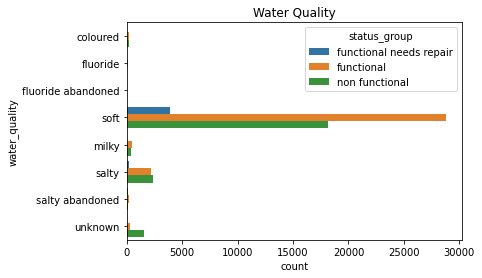

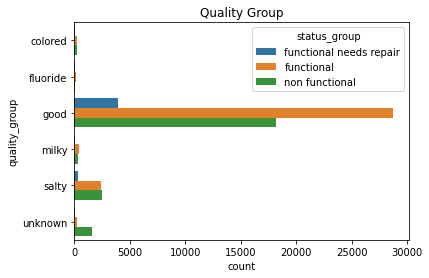

In [91]:
sns.countplot(data=df, y='water_quality', hue='status_group', dodge=1.0)
plt.title('Water Quality')

plt.figure()
sns.countplot(data=df, y='quality_group', hue='status_group', dodge=1.0)
plt.title('Quality Group')

Observations :
- water_quality has 8 categories while quality_group has 6 categories.

Suggestions :
- At first glance, might be advisable to use **water_quality** instead of **quality_group** as it is possible for water_quality to be abandoned but functional. (**To be reviewed during modelling stage**).

### 1.1.13 Quantity / Quantity_Group

In [93]:
df.sort_values(by='quantity', inplace=True)
print(df['quantity'].unique())

df.sort_values(by='quantity_group', inplace=True)
print(df['quantity_group'].unique())

['dry' 'enough' 'insufficient' 'seasonal' 'unknown']
['dry' 'enough' 'insufficient' 'seasonal' 'unknown']


In [95]:
df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [96]:
df['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [97]:
print(len(df['quantity'].unique()))

print(len(df['quantity_group'].unique()))

5
5


Text(0.5, 1.0, 'Quantity Group')

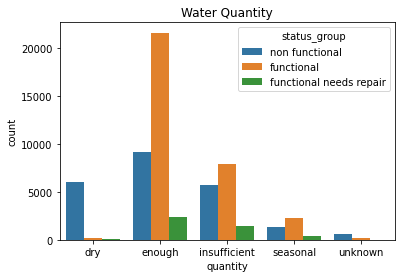

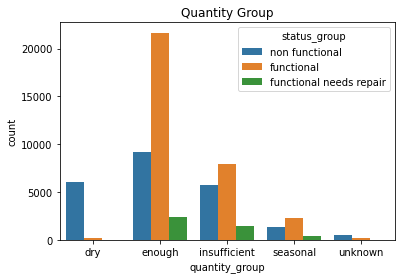

In [98]:
sns.countplot(data=df, x='quantity', hue='status_group', dodge=1.0)
plt.title('Water Quantity')

plt.figure()
sns.countplot(data=df, x='quantity_group', hue='status_group', dodge=1.0)
plt.title('Quantity Group')

Observations :
- Both **quantity** and **quantity_group** columns represent the same values.
- Both columns have the same number of classess at **5**.

Suggestions :
- Select either one and drop the other. (if applicable)

### 1.1.14 Source / Source_Type / Source_Class

In [100]:
df.sort_values(by='source', inplace=True)
print(df['source'].unique())

df.sort_values(by='source_type', inplace=True)
print(df['source_type'].unique())

df.sort_values(by='source_class', inplace=True)
print(df['source_class'].unique())

['dam' 'hand dtw' 'lake' 'machine dbh' 'other' 'rainwater harvesting'
 'river' 'shallow well' 'spring' 'unknown']
['borehole' 'dam' 'other' 'rainwater harvesting' 'river/lake'
 'shallow well' 'spring']
['groundwater' 'surface' 'unknown']


In [101]:
df['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [102]:
df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [103]:
df['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [104]:
print(len(df['source'].unique()))

print(len(df['source_type'].unique()))

print(len(df['source_class'].unique()))

10
7
3


Text(0.5, 1.0, 'Source Class')

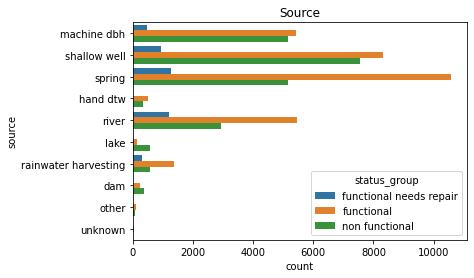

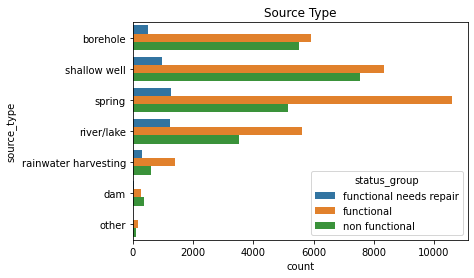

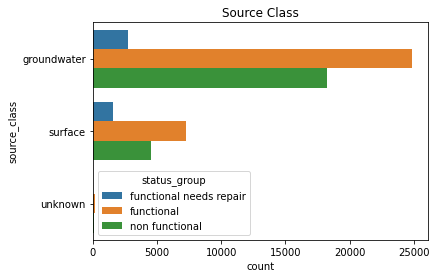

In [105]:
sns.countplot(data=df, y='source', hue='status_group', dodge=1.0)
plt.title('Source')

plt.figure()
sns.countplot(data=df, y='source_type', hue='status_group', dodge=1.0)
plt.title('Source Type')

plt.figure()
sns.countplot(data=df, y='source_class', hue='status_group', dodge=1.0)
plt.title('Source Class')

Observations :
- Certain values in **source_type** can represent values in **source** column without the need of new categories.
- **source_class** column's data that is too abstract.

Suggestions :
- Use **source_type** instead of the other 2 columns.

### 1.1.15 Waterpoint_Type / Waterpoint_Type_Group

In [106]:
df.sort_values(by='waterpoint_type', inplace=True)
df['waterpoint_type'].unique()

df.sort_values(by='waterpoint_type_group', inplace=True)
df['waterpoint_type_group'].unique()

array(['cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [107]:
df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [108]:
df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [109]:
print(len(df['waterpoint_type'].unique()))

print(len(df['waterpoint_type_group'].unique()))

7
6


Text(0.5, 1.0, 'Waterpoint Type Group')

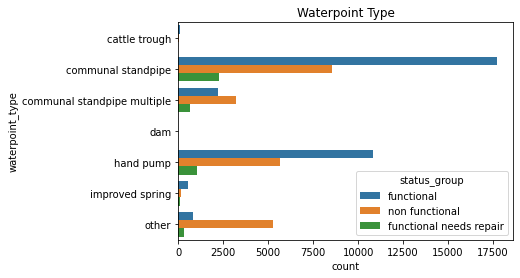

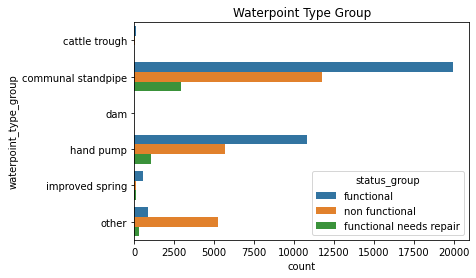

In [110]:
sns.countplot(data=df, y='waterpoint_type', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type')

plt.figure()
sns.countplot(data=df, y='waterpoint_type_group', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type Group')

Observations :
- Communal Standpipe in waterpoint_type_group can represent communal standpipe multiple in **waterpoint_type** column.

Suggestions :
- Use **waterpoint_type_group** and drop the other . (If applicable)

# 2.0 Data Cleaning

In [4]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

## 2.1 Imputation

### 2.1.1 Lat/Lon Imputation

First, we wanted to impute the lat/lon data as some of it was (0, 0). We have done this using the `region`

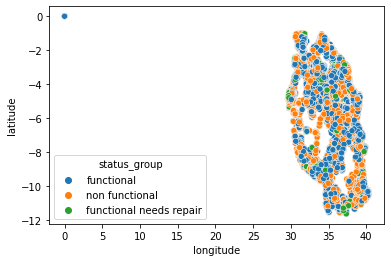

In [196]:
# Author [Tom]

## Original Data
sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.show()

In [197]:
# Author [Tom]

df['longitude'].replace(0, np.nan, inplace=True)
df['longitude'] = df['longitude'].fillna(df.groupby('region')['longitude'].transform('mean'))
df.loc[df['latitude'] == -2.000000e-08, 'latitude'] = np.nan
df['latitude'] = df['latitude'].fillna(df.groupby('region')['latitude'].transform('mean'))

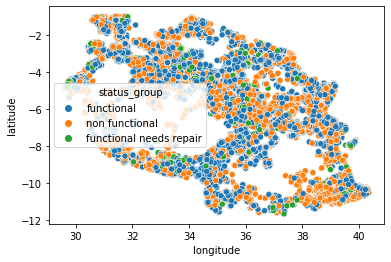

In [198]:
# Author [Tom]

## New Data
sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.show()

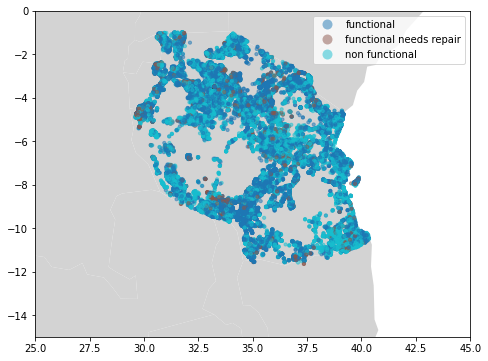

In [199]:
# Author [Tom]

## The data overlayed on an actual map of Tanzania.

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(10, 6), facecolor="lightgrey"), column='status_group', alpha=0.5, legend=True, markersize=10);
ax.set_xlim(25, 45)
ax.set_ylim(-15, 0)
plt.show()


## 2.2 Column Binning

### 2.2.1 Funder & Installer

The funder and installer columns are quite similar in terms of values, we wanted to bin them into categories of:

    - Foreign Aid
    - National Government
    - Local Goverment
    - Religious
    - Private
    - Charity
    - School
    - Unknown

Unfortunately, we could not find a method to do this automatically, we tried NER (https://spacy.io/api/entityrecognizer). However, due to the rare nature of the data this didn't work. We had to do this by hand.

Here are the lists of values that comprise each class. We also made some assumptions on certain values

    - Any acronyms that are similar to a known acronym are classed as that acronym
            - 'Rwssp' is the known acronym; 'Rwsssp', 'Rssp', 'Wrssp' are all classed as 'Rwssp'
    - Some funder are just the water supply from which the water comes. These are classed as private companies
    - Schools & Universities are classed as local governments as they are often public schools, so the money comes from the council
    - DWE stands for District Water Engineer, however this is grouped with multiple parties such as NORAD (gov) or RCC (regilous). When DWE is on it's own it is local_gov, however what it is grouped with takes priority.
    - RWE (or regionwal WE) are government entities.

In [200]:
foreign = ['Danida', 'Germany Republi','Netherlands', 'Norad','Jica', 'Jaica',
          'Nethalan', 'Swedish', 'Germany','China Government' 'Dwe/norad', 'Tz Japan',
          'European Union', 'Dads', 'Holland', 'Swiss If', 'Jika', 'Nethe', 'Dadis',
          'Norad/ Kidep', 'The People of Japan', 'Finland Government', 
          'A/co Germany', 'Us Embassy', 'Finland', 'Jeica', 'Aco/germany',  'Canada',
          'Belgian Government', 'People Of Japan', 'World Bank', 'British Colonial Government',
          'France', 'Gaica', 'U.S.A', 'Greec', 'Sweden', 'Japn Embassy',
          'Colonial Government', 'Japan Aid', 'Italy Government', 'Usa Embassy', 'China Government',
           'Watu Wa Ujerumani',  'Norad /government', 'Un', 'The People Of Japan', 'Eu/acra',
           'Ubalozi Wa Marekani', 'Franc', 'Comune Di Roma', 'Japan Food',  'Netherland', 'Korea', 'Japan Embassy',
           'Danida /government', 'World Bank/government', 'Unhcr/government', 'Norad/government', 'Japan Government', 'Irish Government',
           'Egypt Government',  'Iran Gover', 'Italy', 'British Tanza',  'People From Japan','Norad/ Tassaf Ii',
           'Niger', 'Morad', 'Sweeden', 'Dqnida', 'Holand', 'Norad/ Tassaf', 'Foreigne', 
           'Watu Wa Marekani', 'Italian', 'Natherland', 'Ubalozi Wa Japani', 'Japan  Food Aid Counter Part', 
           'Embasy Of Japan In Tanzania', 'People From Egypt', 'Daida', 'Nerthlands', 'Norad/rudep', 'Norad/japan', 'Netherla', 'People Of Sweden',
           'Canada Aid', 'Unhcr/danida', 'Danid', 'DANID', 'DA', 'Egypt Technical Co Operation', 'Eu',
           'Irish Ai', 'Friend From Un', 'Japan', 'Grobal resource alliance', 'Japan Food Aid', 'Ddca',
           'WOULD BANK', 'Belgiam Government', 'NORAD/', 'China', 'JAICA CO', 'AUSTRALIA', 'Belgij',
           'ITALI', 'DENISH', 'IRAN GOVERN', 'NIRAD', 'Word Bank', 'Britain', 'British government',
           'WORLD NK', 'Chinese', 'Wizra ya maji na egypt', 'Hilfe Fur Bruder', 'DANIDS', 'DANNIDA',
           'Italian government', 'GERMAN', 'Word bank', 'Tanz/Egypt technical coopera',
           'WORDL BANK',
          ]

In [201]:
gov = ['Government Of Tanzania', 'Rwssp', 'Ministry Of Water',  'Lga', 'Dwsp',
        'Rural Water Supply And Sanitat', 'Wsdp','Tanza', 'Kuwait', 'Finida German Tanzania Govt', 
       'Dwssp', 'Cipro/government', 'Water Board',  'Tanzania', 'Isf/government', 'Rwsp',
       'Government/ Community', 'Finidagermantanzania Govt', 'Government/ World Bank',  'Member of Parliament',
       'Government /tassaf',  'Rwsssp',  'Tassaf/ Danida', 'Rwssp/wsdp', 'Ministry of Education',
        'Rssp','Koica and Tanzania Government','Ministry of Water', 'Dhv', 'Water', 'Rudep', 'W.B',
       'Tassaf', 'Undp', 'Gtz', 'Padep', 'National Rural','Idara Ya Maji',  'Dwe/norad', 'Serikali', 
       "Dhv\\norp",'Ifad','Tanzakesho', 'Dhv Moro', 'Rural Water Supply And Sanita', 'National Rural And Hfa',
       'Dhv/gove', 'Bffs', 'Tassaf Ii', 'Parastatal','Ministry Of Education', 'Wrssp', 'Tcrs /government',
       'Domestic Rural Development Pro', 'Rural Drinking Water Supply', 'Kaemp' ,'Tasaf And Lga',
       'Tasaf Ii' ,'Tasae', 'Taasaf', 'Isf / Tasaff','Tasaf And Lga', 'Tasaf And Mmem',
       'Tasaf 1', 'Tasaf/tlc', 'Tasa', 'Rural Water Department','Water Sector Development',
       'Water Department', 'Domestic Water Supply Project','District Rural Project', 'Vgovernment', 
       'Government /sda', 'Misri Government','Government And Community', 'Government/tassaf',
       'Government/tcrs','Government /world Vision', 'Government', 'Handeni Trunk Main(',
       'Domestic Rural Development Pr',  'Ministry Of Agricultura','Ministry Of Healthy', 'Rwssp Shinyanga',
       'Government Of Misri', 'Tassaf I',  'Overnment',  'Rudep/norad','Rudep /dwe', 
       'Tasf', 'Ded/rwssp', 'Dwe/rudep', 'Health  Ministry', 'Go', 'Dh',
       'Ridep', 'Tredep', 'Kirdep', 'Tridep', 'Kidep', 'Redep', 'Padep(mifugo)',
       'Dasip', 'Pidp', 'Asb', 'Ukiligu', 'Rdc', 'Imf', 'Sao H',  'Benguka', 'Dasp', 'Healt', 'Mem', 'Cbhi',
       'Nsc', 'Ddp', 'Hesawz', 'Dbspe', 'Tanapa', 'Tanap', 'Pmo', 'Simmors', 'Wizara', 'Doddea', 'Tirdo',
        'Rural Water Supply', 'Dassip', 'Sswp', 'Tanroad', 'Tpp', 'Wajerumani', 'Tasef', 'Tanzania /egypt',
       'Treedap', 'Prodap', 'National Park',  'Afya Department Lindi Rural',
       'Chama Cha Ushirika', 'Wdsp', 'Tanload', 'Hesswa', 'Hesawza','Hewawa', 'Hewasa', 'Isf/gvt', 'Hesawwa',
       'Drwssp', 'Tanzania Egypt Technical Co Op', 'Dagida', 'Hesawa', 'He', 'RWE', 'Central government',
        'Gover', 'Gove', 'Distri', 'Centr', 'MWE', 'Central govt', 'GOVER', 'Central Government',
         'Region water Department',  'RWE/DWE', 'MWE &', 'Wizara ya maji', 'Tanzania Government', 'KIDP',
       'GOVERN', 'TAWASA',  'TAN PLANT LTD', 'GEOTAN', 'NORA','central government', 'Tanz', 'UKILIG',
       'RWE /Community', 'CENTRAL GOVERNMENT', 'RW', 'Canada na Tanzania', 'RUDEP/', 'Ministry of water engineer',
       'RWE/ Community', 'RUDE', 'RWE/Community', 'ADRA /Government', 'Cental Government', 'TASAF/', 'WE',
       'Cebtral Government', 'UN ONE', 'KOICA', 'Tanzanian Government', 'TASSAF /TCRS', 'Plan Tanzania',
       'GOVERM', 'World banks','GOVERNME', 'RWE Community', 'Selikali', 'World Division', 'REDAP',
       'CIPRO', 'Governme', 'TANCRO', 'TAIPO', 'RWE/TCRS', 'Noshad', 'Handeni Trunk Main',
       'Mpango wa Mwisa', 'Centra Government', 'HEESAW', 'Governmen', 'HESAW', 'TASAF and Comunity',
       'DWE /TASSAF', 'HESAWS', 'Cetral government /RC', 'Centra govt',
      ] 


In [202]:
local_gov = ['District Council', 'Mkinga Distric Coun', 'Mkinga Distric Cou', 'Kibaha Town Council',
            'Village Government', 'Songea District Council', 'Songea Municipal Counci',
            'Wua', 'Villagers', 'Village Council', 'Community', 'Muwsa', 'Halmashauri Ya Wilaya Sikonge',
             'Hsw', 'Vwc', 'Ncaa', 'Mkinga  Distric Cou', 'Losaa-kia Water Supply', 'Commu',
             'Kilindi District Co', 'Tabora Municipal Council',  'Kuwasa', 'Mbiuwasa',
             'Water User As', 'Tuwasa', 'Halmashauri', 'Village', 'Kilwater', 'Village Community',
             'Sekei Village Community', 'Singida Yetu', 'Sowasa', 'Makonde Water Population', 
             'Sumbawanga Munici', 'Bahewasa', 'Olgilai Village Community', 'Village Council/ Haydom Luther',
             'Halmashauri Ya Manispa Tabora', 'Lgcdg', 'Lowasa', 'Kinapa', 'Auwasa', 'Suwasa', 'Mzinga A',
             'Serikali Ya Kijiji', 'Regional Water Engineer Arusha', 'Water User Group', 'Ikela Wa', 'Council',
             'Sengerema District Council', 'Mtuwasa', 'Mamlaka Ya Maji Ngara', 'Halmashaur', 'Mbozi District Council',
             'Village Govt', 'Sauwasa', 'Kyela Council', 'Duwas' ,'Sangea District Council', 'Municipal Council',
             'Mheza Distric Counc', 'Ilkeri Village', 'Kigoma Municipal', 'Mwanga Town Water Authority',
             'Local', 'Villa', 'Mtuwasa And Community', 'Ngiresi Village Community', 'Liuwassa', 'Nduku Village',
             'Oldadai Village Community', 'Halmashauri Ya Wilaya', 'Mdrdp', 'Ndrdp', 'Government/school',
             'Muwasa', 'Dawasa', 'Suasa', 'Village Water Commission', 'Kigoma Municipal Council',
             'Villege Council', 'Village Council/ Rose Kawala', 'Wb / District Council', 'Cdtfdistrict Council',
             'Village Fund', 'Halmashauli', 'Solar Villa', 'Gesawa', 'Villaers', 'Comunity Construction Fund',
             'Village Contributio', 'Dar Es Salaam Round Table', 'Marumbo Community', 'Village Communi',
             'Gra Na Halmashauri', 'Kitiangare Village Community', 'Halmashauri Wil', 'Village Office',
             'Subvillage', 'Tcrs/village Community', 'Village Res', 'Villagers Mpi', 'Villegers', 'Villages',
             'Villlage Contributi', 'Ilwilo Community', 'Kwa Ditriki Cho', 'Tlc/community', 'Halimashauli',
             'Okutu Village Community', 'Buluga Subvillage Community', 'Nyamingu Subvillage', 'Igolola Community',
             'Town Council', 'Community Bank', "Oak'zion' And Bugango B' Commu", 'School', 'Longido Sec School',
              'Mdc', 'Isingiro Ho', 'Rundu Man', 'Runduman', 'Lvemp', 'Lgdcg', 'Lgcbg', 'Ifakara', 'Lcdg', 
             'Ardhi Instute', 'Education Funds', 'Mfuko Wa Jimbo La Magu',
             'Kondo Primary', 'Maseka Community', 'Cdft',  'Lgcgd', 'Manyovu Agriculture Institute',
             'Selikali Ya Kijiji', 'Wanakijiji', 'Kwa Mzee Waziri', 'Kijij', 
             'Sengerema Water Department', 'Magadini-Makiwaru wa', 'Dwe',
             'District water department', 'Adra/Community', 'Adra /Community', 'Communit',
             'District water depar', 'DWE}', 'District Counci', 'VILLAG', 'Vill', 'Ardhi water well',
             'DWE/', 'Sangea District Coun', 'COUN', 'VILLAGE COUNCIL Orpha', 'Songea District Coun',
             'SHUWASA', 'DADS/village community', 'Counc', 'District  Council', 'Serengeti District concil',
             'DEE', 'Village Counil', 'Halmashauri/Quick win project', 'Villager', 'Maendeleo ya jamii',
             'NDDP', 'Municipal', 'Comunity', 'VILLAGER', 'Village water committee', 'MDRD_',
             'ESAWA', 'Water users Group', 'District Community j', 'Water boards', 'Village community members',
             'Lindi rural water department', 'Engarasero villagers', 'Distric Water Department',
             'VILLAGE COUNCIL .ODA', 'Taboma/Community', 'Villi', 'villigers', 'MBULU DISTRICT COUNCIL',
             'DWE/Ubalozi wa Marekani', 'Ubalozi wa Marekani /DWE', 'DWE/TASSAF', 'DWE&',
            ] 

In [203]:
school = ['Secondary Schoo', 'Kwang-nam Middle-school', 'Schoo', 'Loliondo Secondary', 'Mbozi Secondary School',
         'Prince Medium School', 'Kibaha Independent School', 'Eastmeru Medium School', 'Overland High School',
             'Luchelegu Primary School', 'School Adm9nstrarion', 'Tingatinga Sec School', 'Poland Sec School',
             'Manyota Primary School', 'S.P.C Pre-primary School', 'Upendo Primary School',
         'Mwl. Nyerere Sec. School', 'Shule Ya Sekondari Ipuli', 'Shule Ya Msingi', 'Shule Ya Msingi Ufala',
          'Kagunguli Secondary', 'Scholastica Pankrasi', 'Sekondari', 'Orphanage', 'Zingibali Secondary',
          'secondary school',
         ]

In [204]:
private = ['Private Individual', 'Adb', 'Private', 'Ces(gmbh)', 'Shipo', 'Ces (gmbh)',
          'African Development Bank', 'Bank', 'Private Owned', 'Williamsom Diamon Ltd', 'I.E.C',
          'Priva', 'Tulawaka Gold Mine', 'Nyamongo Gold Mining', 'Geita Goldmain',
          'Kiliwater', 'Wananchi', 'Dfid', 'Donor', 'Jbg', 'Aar', 'Biore', 'Songas', 'Bgm', 'Sabodo',
           'Mwaya Mn', 'Swisland/ Mount Meru Flowers', 'Tado', 'Resolute Mining',
           'Fpct', 'Bulyahunlu Gold Mine', 'Snv Ltd', 'Williamson Diamond Ltd', 'Hortanzia',
           'Professor Ben Ohio University', 'Member Of Parliament', 'San Pellegrino', 'Simon Lusambi',
           'Robert Loyal', 'Dawasco', 'Regwa Company Of Egypt',  'Jgb', 'Lawatefuka Water Supply', 'Sabemo',
           'Lawate Fuka Water Supp', 'Fresh Water Plc England', 'Resolute Golden Pride Project',
           'Regina Group', 'Ngelepo Group', 'Ikeuchi Towels Japan', 'Fiwater', 'Swisland/mount Meru Flowers',
           'Ten Degree Hotel', 'African Barrick Gold', 'Bio Fuel Company', 'Vicfish Ltd', 'Kibo Brewaries',
           'Stephano Paulo', 'Steven Nyangarika', 'Geochaina', 'Losakia Water Supply', 'Safari Roya',
           'Mzungu Paul', 'Lawate Fuka Water Suppl', 'Hotels And Loggs Tz Ltd', 'Private Person',
           'Regwa Company Of Egpty', 'Judge Mchome', 'Mmg Gold Mine', 'Company', 'Egypt', 'Peter Tesha',
           'Peter Ngereka','Peters', 'Peter', 'Institution', "Lee Kang Pyung's Family", 'Wafidhi Wa Ziwa T',
           'John Gileth', 'Private Individul', 'Member Of Perliament Ahmed Ali', 'Richard M.Kyore',
           'Bonite Bottles Ltd', 'Robert Mosi', 'Private Co', 'Otelo Bussiness Company',
           'Peter Mayiro', 'Private Institutions', 'John Skwese', 'Old Nyika Company', 'Paulo Sange',
           'Prof. Saluati', 'Robert Kampala', 'Dasp Ltd', 'Hotels And Lodge Tanzania', 'Kayempu Ltd', 
           'Maswi Drilling Co. Ltd', 'Q-sem Ltd', 'Luke Samaras Ltd', 'Q-sem Ltd', 'Hans', 'Rished',
           'Mkuyu', 'Shule', 'Konoike', 'Magadini Makiwaru Water', 'Tanesco', 'Kijiji', 'Mwelia Estate',
           'Vickfis', 'Mtibwa S', 'Vodacom', 'Greinaker', 'Makonde Water Supply', 'Zao Water Spring',
           'Shanta', 'Railway', 'Abood', 'Vififi', 'Vicfish', 'Investor', 'Game Fronti', 'Greineker',
           'Makondakonde Water Population', 'Eco Lodge', 'Trc', 'Lg', 'Stabex', 'Pori La Akiba Kigosi',
           'Tanga Cement', 'Resolute Mininggolden Pride', 'Makanya Sisal Estate', 'Carmatech',
           'Africaone Ltd', 'Segera Estate', 'Meru Concrete', 'Namungo Miners', 'Camartec',
           'Pwc', 'Kwamdulu Estate', 'Holili Water Supply', 'Kenyans Company', 'CES', 'WEDECO',
           'Lawatefuka water sup', 'Consulting Engineer', 'Losaa-Kia water supp', 'wanan',
           'Local te', 'Local  technician', 'JANDU PLUMBER CO', 'SHY BUILDERS', 'VTECOS',
           'LOCAL CONTRACT', 'CJEJOW CONSTRUCTION', 'Local technician', 'JUIN CO', 'Individuals',
           'Korogwe water works', 'KYASHA ENTERPR', 'NYAKILANGANI CO', 'Hydrotec',
           'Consuting Engineer', 'KIM KIM CONSTRUCTION',  'Naishu construction co. ltd',
           'Regional Water', 'SAXON', 'SIA Ltd', 'Pet Corporation Ltd', 'Kiliflora', 'Nandra Construction',
           'Goldstar', 'Maswi company', 'Killflora/ Community', 'Consultant', 'Cosmos Engineering',
           'Consultant Engineer', 'ATIGH BUILDINGS', 'CHINA HENAN CONTRACTOR', 'Maswi', 'Gwaseco',
           'Singida General  Supplies  Ltd', 'AMP contractor', 'ACTIVE TANK CO', 'Kalago enterprises Co.Ltd',
           'Dr. Matomola', 'Kilwa company', 'PIT COOPERATION  LTD', 'Killflora /Community',
           'COSMOS ENG LTD', 'MACK DONALD CONTRACTOR', 'MLAKI CO', 'SEMA CO LTD', 'LVA Ltd', 'SIMBA CO',
           'Baric', 'Lawate fuka water su', 'SAXON BUILDING CONTRACTOR', 'MANYARA CONSTRUCTION', 'Wanjoda',
           'MIDA', 'AMP Contracts', 'WEDECO/WESSONS', 'NANRA contractor', 'YUMBAKA ENGINEERING',
           'AMP Contract', 'MDALA Contractor', 'Clause workers', 'VICTORIA DRILL CO', 'MASWI DRILL',
           'Wanan', 'OBC', 'Consultant and DWE', 'Victoria company', 'MAKAMA CONSTRUCTION', 'MGM',
           'Atlas Company', 'Mombo urban water s', 'GIDA contractor', 'Gold star', 'Howard and humfrey consultant',
           'Ruangwa contractor', 'Wasso companies', 'Maji tech Construction', 'Local technical tec',
           'JLH CO LTD', 'UMOJA DRILLING', 'Magadini Makiwaru wa', 'JUIN', 'Dr. Matobola',
           'Losa-kia water suppl', 'Amboni Plantation', 'Maji Tech', 'Halmashauri ya mburu', 'MCHOME',
           'KOBERG Contractor', 'GACHUMA GINERY', 'NYAKILANGANI CONSTRUCTION', 'Wasso contractors',
           'MASWI DRILLING', 'MAZI INVESTMENT', 'Building works Company Ltd', 'MAKE ENGINEERING',
           'FURAHIA TRADING', 'Dr.Matobola', 'Inves', 'VICTORIA DRILL', 'KYASHA ENTREPR',
           'Mombo urban water', 'CJEJOW', 'LINDALA CO', 'Locall technician', 'MWAKI CONTRACTOR',
           'AQUARMAN DRILLERS', 'NYAKILANGANI', 'MBULI CO', 'UMOJA DRILLING CONSTRUCTION', 'YELL LTD',
           'WEDEKO', 'KARUMBA BUILDING COMPANY LTD', 'VICKFI', 'INDIVIDUAL', 'WINNIN SPIRIT CO', 'SHIP',
           'Resolute', 'Hanja Lt', 'Ilolangulu water supply', 'Individual', 'UNIVERSAL CONSTRUCTION',
           'AQAL', 'JHL CO LTD', 'DDCA CO', 'VIEN CONSTRUCTION', 'WINNIN SPIRIT CO LTD', 'TAIPO',
           'MKON CONSTRUCTION', 'MWAKI CONTRACTO', 'Safe Rescue Ltd', 'Rural Drinkung Water Supply',
           'George mtoto company', 'Altai Co. ltd', 'Kiliwater r', 'Building works engineering Ltd',
           'MKONGO CONSTRUCTION', 'UMOJA DRILLING CONTRUCTO', 'MSUKWA CONSTRUCTION COMPANY',
           'Aqwaman Drilling', 'Regwa Company', 'EMANDA BUILDERS', 'MKONG CONSTRUCTION', 'Privat',
           'UMOJA DRILLING CONTRACTOR', 'Village local contractor', 'MKONGO BUILDING CONTRACTOR',
           'SAXON BUILDING CONTRACTORS', 'MASU COMPANY', 'MACK DONALD CONTRSCTOR', 'GLOBAL RESOURCE CO',
           'WINAM CONSTRUCTION', 'Private company', 'REGWA Company', 'Ardhi and PET Companies',
           'SHIPO CONSTRUCTORS', 'Humfreys Co', 'HOWARD HUMFREYS', 'MORNING CONSTRUCTION',
           'Pet Coporation Ltd', 'Maswi drilling co ltd', 'MREMI CONTRACTOR', 'Lindi contractor', 'WINAM  CONSTRUCTION',
           'WINAMU CO', 'GACHUMA CONSTRUCTION', 'KARUMBA BIULDING COMPANY LTD', 'Kwasenenge Group',
           'SEMA Consultant', 'MACK DONALD CO LTD', 'GLOBAL RESOURCE CONSTRUCTION', 'MANDIA CONSTRUCTION',
           'Private Technician', 'wananchi technicians', 'CF Builders', 'Private individuals',
           'SPAR DRILLING', 'John kiminda co', 'KARUMBA BIULDING CONTRACTOR', 'Howard and Humfrey Consultants',
           'KILANGANI CO', 'WINAM CO'
          ]  

In [205]:
religious = ['Roman Catholic','Kkkt', 'Rc Church', 'Dmdd', 'Kkkt_makwale', 'Anglican Church', 'Kkkt Church',
            'Islamic Found', 'Churc', 'Rc Churc', 'Roman Cathoric-same', 'Missionaries',
            'Rcchurce/cefa', 'Islamic', 'Father Bonifasi', 'African Muslim Agency', 'Roman Cathoric Same',
            'Roman Catholic Rulenge Diocese', 'Roman Church', 'Mosque', 'Rc Church/centr',
            'Lutheran Church', 'Germany Misionary', 'Muslims', 'Kkkt-dioces Ya Pare',
            'Morovian Church',  'Roman Cathoric -kilomeni', 'Baptist Church', 'Islam',
            'World Vision / Kkkt', 'Moslem Foundation', 'Church', 'Free Pentecoste Church of Tanz',
            'Rc Cathoric', 'Rc Mission', 'Tag Church', 'Musilim Agency', 'Roman Ca', 'Fpct Church', 'Roman',
             'Rc Ch', 'Aict', 'Wvt', 'Caritas', 'Kanisa Katoliki Lolovoni', 'Kiuma', 'Hw/rc', 'Kanisa La Menonite',
             'Rcchurch/cefa', 'Sda', 'Kanisa', 'Angrikana', 'World Vision/rc Church', 'Full Gospel Church',
             'Kanisa Katoliki', 'Rc/mission', 'Christian Outrich', 'Free Pentecoste Church Of Tanz',
             'Loliondo Parish', 'Missionary', 'Pentecosta Church', 'Abasia' ,'Kkkt Leguruki',
             'Kkkt Ndrumangeni', 'Kkkt Dme', 'Kkkt Canal', 'Kkkt Usa', 'Kkkt Mareu', 'Kkkt Dme',
             'Christan Outrich', 'Nazalet Church', 'Cefa/rcchurch', "Gil Cafe'church'", 'Haidomu Lutheran Church',
             "Ju-sarang Church' And Bugango", 'Roman Cathoric Church', 'Tag Church Ub' ,'Aic Church',
             'Bukwang Church Saints', 'Agt Church', 'Church Of Disciples', 'Pentecostal Church',
             'Bukwang Church Saint', 'Eung Am Methodist Church', 'Sda Church', 'Methodist Church',
             'Nazareth Church', 'St Magreth Church', 'Pag Church', 'Batist Church', 'Dwe/anglican Church',
             'Eung-am Methodist Church', 'Islamic Agency Tanzania', 'Arabs Community', 'Shear Muslim',
             'Father W', 'The Islamic', 'Sister Francis', 'Moravian', 'Morovian', 'Diocese Of Geita',
             'Dmk Anglican', 'Siter Fransis', 'German Missionary', 'Heri Mission','Cg/rc', 'Germany Cristians',
             'Unicef/african Muslim Agency', 'Rc/dwe', 'St Elizabeth Majengo', 'Neemia Mission', 'Missio',
             'Dioce', 'Roman Cathoric', 'Romam Catholic', 'Tcrs /care', 'Tcrs/care', 'Cipro/care/tcrs',
             'Cipro/care', 'Islamic Community', 'Islamic Society', 'Muslimu Society(shia)', 'Answeer Muslim Grou',
             'Kome Parish', 'Pentecosta Seela', 'Muislam', 'Cristan Outrich', 'Muslimehefen International',
             'Wamisionari Wa Kikatoriki',  'Germany Missionary', 'Cathoric', 'Muslim World', 'Rc Msufi',
             'Pentekoste', 'Muslim Society', 'Nyabibuye Islamic Center', 'Pentecost', 'Sister Makulata',
             'Morrovian', 'Rc Missi', 'Rc Njoro', 'Caltas Tanzania', 'Kalebejo Parish', 'Pentecostal Hagana Sweeden',
             'Grail Mission Kiseki Bar', 'Pentecostal', 'Arab Community', 'Mosqure', 'Rc Missionary',
             'Diocese Of Mount Kilimanjaro', 'Kilimarondo Parish', 'Rc Mofu', 'Bruder', 'Msikiti', 'Elct',
             'Aic', 'St Ph', 'Lutheran', 'Cpps', 'Floresta', 'Irevea Sister', 'Hydom Luthelani', 'Agape Churc',
             'Fosecu', 'Tcrs Kibondo', 'Tcrst', 'Arabi', 'Kanisa La Tag', 'Rc Mi', 'Usambala Sister',
             'Kanisani', 'Kanisa La Mitume', 'St Gasper', 'Cpps Mission', 'Wamissionari Wa Kikatoriki',
             'Kanisa La Neema', 'KKKT _ Konde and DWE', 'Angli', 'Rc', 'KKT', 'Fathe', 'Ndanda missions',
             'RC church/Central Gover', 'RC C', 'TAG', 'CARTAS', 'ANGLI', 'KKT C', 'Masjid', 'Luthe',
             'KK', 'KMT', 'Africa Islamic Agency Tanzania', 'African Muslims Age', 'Msiki', 'R.C',
             "TAG Patmo's", 'Calvary connection', 'RC CHURCH BROTHER', 'anglican Uganda', 'KKKT Katiti juu',
             'Romam', 'Anglikan', 'RC .Church', 'RC Mis', 'Anglica Church', 'Pentecosta',
             'Pump entecostal Sweeden', 'MasjId Takuar', 'Pentecost church', 'AFRICA MUSLIM', 'GERMAN MISSIONSRY',
             'KKKT Kilinga', 'Anglican Uganda', 'ANGLIKANA CHURCH',
            ]   

In [206]:
charity = ['World Vision', 'Unicef', 'Oxfam', 'Oxfarm', 'Fini Water', 'Wateraid', 'Amref',
           'Mission', 'Adra', 'Magadini-makiwaru Water', 'Oikos E.Afrika', 'Unice', 'Concern World Wide',
           'Concern', 'Fin Water', 'Water Aid /sema', 'Plan International', 'Cocen', 'Red Cross', 'Finn Water',
           'Oikos E.Africa/european Union', 'ICS', 'The Desk and Chair Foundat',
          'Happy Watoto Foundation', 'Finwater', 'Cocern', 'Save the Rain Usa', 'Water Aid/sema',
          'Care International', 'Plan Internatio', 'Wwf', 'Rotary Club', 'Oxfam Gb',
           'Water Project Mbawala Chini', 'Living Water International', 'Unicef/central',
           'Desk and Chair Foundation', 'Women For Partnership', 'Action Aid', 'Africare',
           'African Development Foundation', 'Unicef/ Csp', 'Wate Aid/sema', 'Concern /govern',
           'Oikos E .Africa/european Union', 'Cocen', 'Concern/governm', 'Tasaf', 'Tcrs', 'Hifab', 'Finw',
           'Isf', 'Ded', 'Plan Int', 'Unhcr', 'Snv', 'Missi', 'Cmsr', 'Cdtf', 'Conce', 'Marafip', 'Cefa',
           'Twesa', 'wfp', 'Usaid/wfp', 'Wfp/tnt', 'Wfp/usaid/tnt', 'Wfp/usaid', 'Wfp/tnt/usaid', 'Wfp',
           'Devon Aid Korogwe', 'Acra', 'Shawasa', 'Cafod', 'Tdft', 'Ilo', 'Ics', 'The Desk And Chair Foundat',
           'World Vision/adra', 'Save The Rain Usa', 'Undp/ilo', 'Il', 'I Wash', 'Mileniam Project',
           'Total Land Care', 'Cefa-njombe', 'Killflora', 'Msf', 'Peace Cope', 'Drdp Ngo', 'Idydc', 'Tahea',
           'Livin', 'African Relie', 'Msf/tacare', 'Undp/aict', 'Secondary', 'Lifetime', 'Millenium', 'Tasafu',
           'Tasaf/dmdd', 'Chamavita', 'Desk And Chair Foundation', 'Kadres Ngo', 'Action Contre La Faim',
           'Kingupira S','Milenia', 'Lottery Club', 'Rotary Club Of Usa And Moshi', 'Summit For Water',
            'Ngos', 'Jeshi La Wokovu', 'Total Landcare', 'Concen', 'Dwe/bamboo Projec',
             'Uhai Wa Mama Na Mtoto', 'Mavuno Ngo', 'African',
           'No', 'World Vision/ Kkkt', 'Hospital', 'Rotary I', 'Bingo Foundation', 'Quick Win Project',
           'Quickwi', 'Quwkwin', 'Quick','Qwickwin', 'Quick', 'Quick Wings', 'Quick Wins', 
           'Quik', 'Quick Win Project /council', 'Oikos', 'Lvia', 'Twe', 'Dw', 'Adp', 'Magoma Adp',
           'Adp Mombo', 'Kadp', 'Dadp', 'Oxfarm Gb', 'Ox',
           'Kindoroko Water Project', 'Rilayo Water Project', 'Africa Project Ev Germany', 'Kamata Project',
           'Kibara Foundation', 'Kuji Foundation', 'Friends Of Kibara Foundation', 'Kombe Foundation',
           'Bingo Foundation Germany', 'African Reflections Foundation', 'Ngo', 'Rotary Club Australia',
           'Lotary Club', 'Rotary Club Of Chico And Moshi', 'Rotary Club Kitchener', 'Rotaty Club', 'Lions Club',
           'Lions Club Kilimanjaro', 'Un/wfp', 'Tlc/john Majala', 'Bread For The Wor', 'Unicef/cspd', 'Kdrdp Ngo',
           'Lions', 'Cartas Tanzania', 'Usaid', 'Asdp', 'Tumaini Fund', 'Bridge North', 'Rotery C', 'Quickwins',
           'Action In A', 'Lottery', 'Friedkin Conservation Fund', 'Care Int', 'Redcross', 'African Realief Committe Of Ku',
           'Africa 2000 Network', 'Acord Ngo', 'The Isla', 'Tacare', 'Isf/tacare', 'Tina/africare',
           'Totoland Care', 'Care/dwe', 'Totaland Care', 'Vifafi', 'Engineers Without Border', 'Quick Win', 'Qwckwin',
           'Unicet', 'Goldwill Foundation', 'Lotary International', 'Rotary', 'Quicklw', 'Water Aid/dwe',
           'Uniseg', 'Compasion International', 'Tkc', 'Tquick Wings', 'Hesawa And Concern World Wide',
           'Wwf / Fores', 'Oikos E.Africa/ European Union', 'Qwick Win', 'Tlc/jenus Malecha', 'Uniceg',
           'Worldvision', 'Tlc/emmanuel Kasoga', 'One Desk One Chair', 'Unicrf', 'Women Fo Partnership',
           'Afriican Reli', 'Hearts Helping Hands.Inc.', 'Qwekwin', 'Bread Of The Worl', 'International Aid Services',
           'Unice/ Cspd', 'Shirika La Kinamama Na Watot', 'Lions C', 'Tadepa', 'Sema', 'Udc/sema', 'Water /sema', 'Sema S',
           'Semaki K', 'Giz', 'Tlc', 'Partage', 'Cspd', 'Ilct', 'Efg', 'Ereto', 'Msabi', 'Snv-swash', 'Swash', 
           'Dar Al Ber', 'Prf', 'Lwi', 'Idea', 'Nado', 'Pci', 'Trachoma', 'Caltas', 'Tcrs.Tlc', 'Adap',
           'Farm Africa', 'Simavi', 'Unesco', 'Engin', 'Awf', 'Acord', 'Adp Bungu', 'Eno', 'Africa Amini Alama',
           'Irc', 'Africa 2000 Network/undp', 'Adp/w', 'African 2000 Network', 'Lga And Adb', 'Totoland',
           'Quick Win/halmashauri', 'Tanedaps Society', 'Hapa Singida', 'Un Habitat', 'Amrefe', 'Gurdians',
           'Chmavita', 'Ramsar', 'Fredked Conservation', 'Wcst', 'Lion Clu', 'Rudri', 'Wsdo', 'Sipdo',
           'Kikundi Cha Akina Mama', 'Tlc/sorri', 'Farm-africa', 'Busoga Trust', 'Tlc/thimotheo Masunga',
          'Karadea Ngo', 'Aqua Blues Angels', 'Quick Wins Scheme',"Tlc/seleman Mang'ombe", 'Afdp', 'FW', 'World',
           'WATER AID', 'Unisef', 'Oikos E .Africa', 'Water Aid', 'CBHCC', 'Wfp/usaid', 'TPP TRUSTMOSHI', 'ADP Busangi',
           'Mviwa', 'World Vission', 'HAPA', 'WATER  AID', 'TLTC', 'REDESO', 'Concern /government',
           'Save the rain', 'Mileniam', 'Summit for water/Community', 'Oikos E. Africa', 'TWESA /Community',
           'Water  Aid/Sema', 'TRUST', 'DESK C', 'Africa', 'HIAP', 'People P', 'TCRS/TLC', 'Oikos E Africa',
           'Milenium', 'Efarm', "LION'S", 'AFRICA', 'TCRS /TWESA', 'TCRS TWESA', 'WWF/', 'QUKWIN', 'AGRICAN',
           'FinWate', 'TWESA/JAMII', 'TCRS a', 'CARE/CIPRO', 'COMPASION INTERNATIO', "Lion's club",
           'World Visiin', 'TCRS/ TASSAF', 'WATER  AIDS', 'TCRS/DWE', 'ICF/TWESA', 'TLC/Samora',
           "lion's club", 'Water  Aid/Maji tech', 'Africaone', "NGO'S"
          ]

In [207]:
# Author [Tom]

f = lambda x: x.upper().replace(" ", "").translate(str.maketrans('', '', string.punctuation))

gov = list(map(f, gov))
local_gov = list(map(f, local_gov))
private = list(map(f, private))
religious = list(map(f, religious))
charity = list(map(f, charity))
school = list(map(f, school))
foreign = list(map(f, foreign))

In [208]:
# Author [Tom]

def cat_inst_fund(x, f):
    try:
        x = f(x)
        if x in gov:
            return 'Government'
        elif x in local_gov:
            return 'Local Government'
        elif x in private:
            return 'Private'
        elif x in religious:
            return 'Religious'
        elif x in charity:
            return 'Charity'
        elif x in school:
            return 'School'
        elif x in foreign:
            return 'Foreign Aid'
        
        else:
            return 'Unknown'
    except AttributeError as e:
        return 'Unknown'

In [209]:
# Author [Tom]

df['cat_funder'] = df['funder'].apply(lambda x: cat_inst_fund(x, f))
df['cat_funder'].value_counts()

Government          20199
Charity             11066
Unknown              8216
Foreign Aid          8131
Religious            4087
Private              3889
Local Government     3774
School                 38
Name: cat_funder, dtype: int64

In [210]:
# Author [Tom]

df['cat_installer'] = df['installer'].apply(lambda x: cat_inst_fund(x, f))
df['cat_installer'].value_counts()

Local Government    22515
Government          10327
Unknown              8800
Charity              7487
Private              3853
Foreign Aid          3346
Religious            3046
School                 26
Name: cat_installer, dtype: int64

An interesting point to note is that `School` does not have many values, so might have be replaced by Local Government at some point.

Now that we have all this data in a list however, we can use it to train our own custom NER (https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/). We will likely test this out later down the line so that we can automate this process for any new (test) data that comes in.

### 2.2.2 Construction Year

In [211]:
# Author [Jason]

# Function for Region Column Binning. 
# Binning done based on the decade.

def label_construction_year (row):
    if row['construction_year'] in range(1960,1970):
        return "60s"
    if row['construction_year'] in range(1970,1980):
        return "70s"
    if row['construction_year'] in range(1980,1990):
        return "80s"
    if row['construction_year'] in range(1990,2000):
        return "90s"
    if row['construction_year'] in range(2000,2010):
        return "2000s"
    if row['construction_year'] in range(2010, 2020):
        return "2010s"
    return "Unknown"

df['construction_decade'] = df.apply(lambda row: label_construction_year(row), axis=1)

In [212]:
# Author [Jason]

df['construction_decade'].value_counts()

Unknown    20709
2000s      15330
90s         7678
80s         5578
2010s       5161
70s         4406
60s          538
Name: construction_decade, dtype: int64

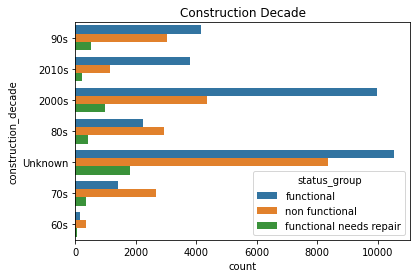

In [213]:
# Author [Jason]

sns.countplot(data=df, y='construction_decade', hue='status_group', dodge=1.0)
plt.title('Construction Decade')
plt.show()

### 2.2.3 Region

In [214]:
# Author [Jason]

# Function for Region Column Binning.
# Region Binning is done based on Data from Tanzania Water and Sanitation Network Website. 

def label_region (row):
    if row['region'] in ['Arusha','Manyara','Kilimanjaro','Tanga']:
        return "Northern Zone"
    if row['region'] in ['Kagera','Mwanza','Shinyanga','Mara']:
        return "Lake Zone"
    if row['region'] in ['Lindi','Ruvuma','Mtwara']:
        return "Southern Zone"
    if row['region'] in ['Rukwa','Mbeya','Iringa']:
        return "Southern Highlands"
    if row['region'] in ['Morogoro','Pwani','Dar es Salaam']:
        return "Coastal Zone"
    if row['region'] in ['Kigoma']:
        return "Western Zone"
    if row['region'] in ['Tabora','Singida','Dodoma']:
        return "Central Zone"
    return "Unknown"

df['zones'] = df.apply(lambda row: label_region(row), axis=1)

In [215]:
# Author [Jason]

df['zones'].value_counts()

Lake Zone             13369
Northern Zone         11859
Southern Highlands    11741
Coastal Zone           7446
Central Zone           6253
Southern Zone          5916
Western Zone           2816
Name: zones, dtype: int64

Text(0.5, 1.0, 'Zones')

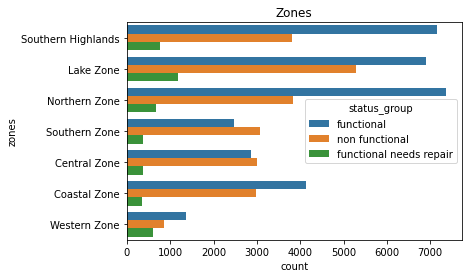

In [216]:
# Author [Jason]

sns.countplot(data=df, y='zones', hue='status_group', dodge=1.0)
plt.title('Zones')

## 2.3 Normalization

## 2.4 Dropping Data

Drop any columns we don't need, plus rows with NANs above a threshold (4/5?)

## 2.5 Feature Encoding